In [62]:
from detectdd import config
from detectdd.serializer import Serializer
import root_config as rc #this is needed to resolve the local modules
rc.configure()

import os
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from detectdd.config import *
from detectdd.auth_bigquery import BigQueryClient

if config.isFastMode():
    print("running in FAST mode")
else:
    print("Running in FULL mode")
    
serializer = Serializer()

running in FAST mode


### Produces:
cohort.out - has ddinter drug interactions
non-drug-interactions.csv - has an administration of a drug from ddinter, without a corresponding interacting drug




In [63]:
def main():
    mimic_drugs = f"""
        SELECT itemid, label, abbreviation, category, unitname
        FROM {icu_d_items}
        WHERE linksto='inputevents' """

    mimic_job = BigQueryClient.auth().query(mimic_drugs)
    df = mimic_job.to_dataframe()
    df.label = df.label.fillna("")
    df.label = df.label.apply(str.lower)
    return df

icu_drugs = main()
print(len(icu_drugs))

<google.oauth2.credentials.Credentials object at 0x0000021166A1E1D0> mimic-iv-desktop
474


In [64]:
icu_drugs

,itemid,label,abbreviation,category,unitname
0,222139,potassium acetate,Potassium ACEtate,Nutrition - Supplements,mEq
1,222190,ranitidine,Ranitidine,Nutrition - Parenteral,mg
2,225801,lipids 20%,Lipids 20%,Nutrition - Parenteral,mL
3,225916,tpn w/ lipids,TPN w/ Lipids,Nutrition - Parenteral,mL
4,225917,tpn without lipids,TPN without Lipids,Nutrition - Parenteral,mL
...,...,...,...,...,...
469,221209,peptisorb,Peptisorb,Fluids - Other (Not In Use),mL
470,221210,suplena,Suplena,Fluids - Other (Not In Use),mL
471,221211,"sodium bicarbonate 1,4%","NaBic 1,4%",Fluids - Other (Not In Use),mL
472,221212,"saline 0,18%","Saline 0,18%",Fluids - Other (Not In Use),mL


In [65]:
from detectdd.drug_index import DrugIndex, index_mimic_drugs, clean

drug_index = DrugIndex.get_drug_index()

drug_index.drug_bank_df['cleaned'] = drug_index.drug_bank_df['Common name'].apply(clean)
drug_index.drug_bank_df

,DrugBank ID,Accession Numbers,Common name,CAS,UNII,Synonyms,Standard InChI Key,cleaned
0,DB00001,BIOD00024 | BTD00024,Lepirudin,138068-37-8,Y43GF64R34,"[Leu1, Thr2]-63-desulfohirudin | Desulfatohiru...",NaN,lepirudin
1,DB00002,BIOD00071 | BTD00071,Cetuximab,205923-56-4,PQX0D8J21J,Cetuximab | Cétuximab | Cetuximabum,NaN,cetuximab
2,DB00003,BIOD00001 | BTD00001,Dornase alfa,143831-71-4,953A26OA1Y,Deoxyribonuclease (human clone 18-1 protein mo...,NaN,dornase alfa
3,DB00004,BIOD00084 | BTD00084,Denileukin diftitox,173146-27-5,25E79B5CTM,Denileukin | Denileukin diftitox | Interleukin...,NaN,denileukin diftitox
4,DB00005,BIOD00052 | BTD00052,Etanercept,185243-69-0,OP401G7OJC,Etanercept | etanercept-szzs | etanercept-ykro...,NaN,etanercept
...,...,...,...,...,...,...,...,...
15230,DB17382,NaN,AUM-601,NaN,NaN,"(R,E)-3-(5-(2-(2,5-difluorophenyl)pyrrolidin-1...",NaN,aum-601
15231,DB17383,NaN,FN-1501,1429515-59-2,6MC966B505,"4-((7h-pyrrolo (2,3-d)pyrimidin-4-yl)amino)-n-...",VXLAKHWYGRKCGI-UHFFFAOYSA-N,fn-1501
15232,DB17384,NaN,Tinengotinib,2230490-29-4,WZ9TJ0L9Y8,"4-(5-(2-Chlorophenyl)-3-Methyl-2,10-Dihydropyr...",DQFCVOOFMXEPOC-UHFFFAOYSA-N,tinengotinib
15233,DB17385,NaN,Lipotecan,1432468-79-5,D47234N30N,"Lipothecan free base | Propanoic acid, 2-(((2,...",JCCCLGDYMMTBPM-HXDHBHDHSA-N,lipotecan


In [66]:
from detectdd.drug_index import clean

def read_hosp_drugs():
    sql_hosp_drugs_query = f"""
    SELECT distinct medication from {config.hosp}.emar"""
    return BigQueryClient.auth().query(sql_hosp_drugs_query).to_dataframe()

df_hosp_drugs = read_hosp_drugs()['medication'].astype(str)

print(f"Number of hosp drugs found {len(df_hosp_drugs)}")
df_hosp_drugs

<google.oauth2.credentials.Credentials object at 0x000002117863F1F0> mimic-iv-desktop
Number of hosp drugs found 4187


0                 Nicotine Patch
1                       Propofol
2              Scopolamine Patch
3               Fentanyl Citrate
4                     Tacrolimus
                  ...           
4182                    Plegridy
4183                      Levo-T
4184            Belladonna-Opium
4185    GenTeal Tears Severe Gel
4186         INV-PEGPH20/Placebo
Name: medication, Length: 4187, dtype: object

In [67]:
pd.DataFrame(df_hosp_drugs)
drugs_by_norm_name = index_mimic_drugs(pd.DataFrame(df_hosp_drugs), "medication", "medication")
drugs= pd.DataFrame.from_dict(drugs_by_norm_name, orient="index")

print(f"Hospital drugs matches against drug bank normalisation {len(drugs)}, {round(100 * len(drugs) / len(df_hosp_drugs), 2)}%")
drugs

Hospital drugs matches against drug bank normalisation 3613, 86.29%


,0
nicotine patch,'Nicotine Patch' -- cleaned_db_name:nicotine p...
propofol,'Propofol' -- cleaned_db_name:propofol -- comm...
scopolamine patch,'Scopolamine Patch' -- cleaned_db_name:scopola...
fentanyl citrate,'fentaNYL citrate' -- cleaned_db_name:fentanyl...
tacrolimus,'tacrolimus' -- cleaned_db_name:tacrolimus -- ...
...,...
plegridy,'Plegridy' -- cleaned_db_name:plegridy -- comm...
levo-t,'Levo-T' -- cleaned_db_name:levo-t -- common_n...
belladonna-opium,'Belladonna-Opium' -- cleaned_db_name:belladon...
genteal tears severe gel,'GenTeal Tears Severe Gel' -- cleaned_db_name:...


In [68]:
icu_drugs_by_norm_name = index_mimic_drugs(pd.DataFrame(icu_drugs), id_col="itemid")
df_icu_drugs = pd.DataFrame.from_dict(icu_drugs_by_norm_name, orient="index")

matched_icu_drugs = len(df_icu_drugs)
print(f"Hospital drugs matches against drug bank normalisation {matched_icu_drugs}, {round((matched_icu_drugs / len(icu_drugs))*100, 2)}%")

Hospital drugs matches against drug bank normalisation 469, 98.95%


In [69]:

def fuzzy_match(str1, str2):
    return fuzz.token_set_ratio(str1, str2)

def match_dataframe(df1, key1, df2, key2, threshold=88): #threshold from inspection of data
    matches = []
    # matches = pd.DataFrame(columns=['index', 'label', 'norm_label', 'match0', 'match1'])
    for i, row in df1.iterrows():
        drug_name = row[key1]
        fast = True
        to_match = df2[key2]
        if config.isFastMode():
            to_match = to_match.loc[to_match.str.startswith(drug_name[0])] # speed up fuzzy matching by only considering synonyms that start with the same letter

        match = process.extractOne(drug_name, to_match, scorer=fuzzy_match)
        print(match)
        matched_label = match[0]
        match_score = match[1]
        match_index = match[2]
        if match_score >= threshold:
            raw_match = df2.loc[match_index]
            norm_label = raw_match[key2]
            print(f"Found match with score ({str(match[1])}) : {row[key1]} - {matched_label} -- norm label {norm_label}")
            matches.append([i, row['itemid'],row[key1], norm_label, matched_label, match_score, match_index])
        print(i)

    return pd.DataFrame(matches, columns=['index', 'itemid', 'label', 'norm_label', 'matched_label', 'score', 'norm_index'])

def fuzzy_merge():
    medications = icu_drugs.loc[(~icu_drugs['category'].isin(['Medications']))]

    proprietary = match_dataframe(medications, "label", drug_index.drug_bank_df, "cleaned")
    return proprietary

fuzzy_matched = fuzzy_merge()
fuzzy_matched

('potassium acetate', 100, 12440)
Found match with score (100) : potassium acetate - potassium acetate -- norm label potassium acetate
0
('ranitidine', 100, 845)
Found match with score (100) : ranitidine - ranitidine -- norm label ranitidine
1
('li-301', 53, 5107)
2
('tildipirosin', 50, 9536)
3
('titanium dioxide', 47, 8453)
4
('amrinone', 60, 1364)
5
('d-arginine', 48, 3788)
6
('pentavalent antimony', 51, 11032)
7
('heptaminol', 80, 11542)
8
('neamine', 82, 4523)
9
('felbamate', 67, 931)
10
('hydrochloric acid', 100, 11340)
Found match with score (100) : hydrochloric acid - hydrochloric acid -- norm label hydrochloric acid
11
('potassium', 100, 12442)
Found match with score (100) : potassium phosphate - potassium -- norm label potassium
12
('sodium acetate', 100, 8387)
Found match with score (100) : sodium acetate - sodium acetate -- norm label sodium acetate
13
('dextrose, unspecified form', 84, 8346)
14
('amino acids', 100, 8385)
Found match with score (100) : amino acids - amino ac

,index,itemid,label,norm_label,matched_label,score,norm_index
0,0,222139,potassium acetate,potassium acetate,potassium acetate,100,12440
1,1,222190,ranitidine,ranitidine,ranitidine,100,845
2,11,225924,hydrochloric acid,hydrochloric acid,hydrochloric acid,100,11340
3,12,225925,potassium phosphate,potassium,potassium,100,12442
4,13,225926,sodium acetate,sodium acetate,sodium acetate,100,8387
...,...,...,...,...,...,...,...
74,428,221001,"dextran 40 / saline 0,9% (gentran - rheomacrodex)",dextran,dextran,100,8262
75,429,221002,dextran 70 / dextrose 5% (gentran - macrodex -...,dextran,dextran,100,8262
76,430,221003,"dextran 70 / saline 0,9% (gentran - macrodex -...",dextran,dextran,100,8262
77,461,221200,fibrini,fibrin,fibrin,92,14455


In [70]:

fuzzy_matched


,index,itemid,label,norm_label,matched_label,score,norm_index
0,0,222139,potassium acetate,potassium acetate,potassium acetate,100,12440
1,1,222190,ranitidine,ranitidine,ranitidine,100,845
2,11,225924,hydrochloric acid,hydrochloric acid,hydrochloric acid,100,11340
3,12,225925,potassium phosphate,potassium,potassium,100,12442
4,13,225926,sodium acetate,sodium acetate,sodium acetate,100,8387
...,...,...,...,...,...,...,...
74,428,221001,"dextran 40 / saline 0,9% (gentran - rheomacrodex)",dextran,dextran,100,8262
75,429,221002,dextran 70 / dextrose 5% (gentran - macrodex -...,dextran,dextran,100,8262
76,430,221003,"dextran 70 / saline 0,9% (gentran - macrodex -...",dextran,dextran,100,8262
77,461,221200,fibrini,fibrin,fibrin,92,14455


In [71]:
icu_drugs

,itemid,label,abbreviation,category,unitname
0,222139,potassium acetate,Potassium ACEtate,Nutrition - Supplements,mEq
1,222190,ranitidine,Ranitidine,Nutrition - Parenteral,mg
2,225801,lipids 20%,Lipids 20%,Nutrition - Parenteral,mL
3,225916,tpn w/ lipids,TPN w/ Lipids,Nutrition - Parenteral,mL
4,225917,tpn without lipids,TPN without Lipids,Nutrition - Parenteral,mL
...,...,...,...,...,...
469,221209,peptisorb,Peptisorb,Fluids - Other (Not In Use),mL
470,221210,suplena,Suplena,Fluids - Other (Not In Use),mL
471,221211,"sodium bicarbonate 1,4%","NaBic 1,4%",Fluids - Other (Not In Use),mL
472,221212,"saline 0,18%","Saline 0,18%",Fluids - Other (Not In Use),mL


In [72]:
def read_ddinter():
    ddinter_files = os.listdir(ddinter_data_dir)

    # loop through ddinter files
    df = pd.DataFrame()
    for file_name in ddinter_files:
        df = pd.concat([df, pd.read_csv(ddinter_data_dir / file_name)])

    df.Drug_B = df.Drug_B.fillna("")
    df.Drug_B = df.Drug_B.apply(clean)

    df.Drug_A = df.Drug_A.fillna("")
    df.Drug_A = df.Drug_A.apply(clean)
    return df

ddinter = read_ddinter()
cleaned= ddinter.loc[ddinter.Level.isin( ['Major'])]
cleaned = cleaned.drop_duplicates()
cleaned

,DDInterID_A,Drug_A,DDInterID_B,Drug_B,Level
2,DDInter58,aluminum hydroxide,DDInter582,dolutegravir,Major
4,DDInter138,attapulgite,DDInter582,dolutegravir,Major
5,DDInter270,calcium acetate,DDInter582,dolutegravir,Major
6,DDInter271,calcium carbonate,DDInter582,dolutegravir,Major
7,DDInter582,dolutegravir,DDInter273,calcium citrate,Major
...,...,...,...,...,...
9531,DDInter1910,valdecoxib,DDInter967,ioxilan,Major
9651,DDInter1831,tolmetin,DDInter957,iodipamide,Major
9652,DDInter1831,tolmetin,DDInter958,iodixanol,Major
9653,DDInter1838,tositumomab,DDInter1831,tolmetin,Major


In [73]:
def get_ddinter_multimap():
    multimap = cleaned.groupby('Drug_A')['Drug_B'].apply(set).to_dict()
    opp_direction = cleaned.groupby('Drug_B')['Drug_A'].apply(set).to_dict()
    for key in opp_direction.keys():
        existing = multimap.get(key)
        if existing is None:
            existing = set()
        existing |= opp_direction[key]
        multimap[key] = existing
    return multimap
    
    multimap

In [74]:
def get_interaction_clause_with_synonyms(with_interactions):
    multimap = get_ddinter_multimap()
    
    clauses= []
    conjunction = 'AND' if with_interactions else 'AND NOT'
    for key in multimap.keys():
        first_ids = fuzzy_matched.loc[(fuzzy_matched['norm_label'] == key)]['itemid']

        second_ids = fuzzy_matched.loc[(fuzzy_matched['norm_label'].isin(multimap[key]))]['itemid']
        if first_ids.any() & second_ids.any():
            sql = f"(first_ie.itemid IN ({','.join([str(item) for item in first_ids if item])}) {conjunction} second_ie.itemid IN ({','.join([str(item) for item in second_ids if item])}))"
            clauses.append(sql)
    print(len(clauses))
    clause = " OR ".join(clauses)
    print (clause)
    print(f"Found {len(clauses)} first ids")
    return clause

In [75]:
def get_interaction_clause_raw(with_interactions):
    multimap = get_ddinter_multimap()
    print(len(multimap))
    clauses= []
    first_match_count = 0
    
    conjunction = 'AND' if with_interactions else 'AND NOT'
    
    for key in multimap.keys():
        first_ids = icu_drugs.loc[(icu_drugs['label'] == key)]['itemid']
        if first_ids.any():
            first_match_count += 1
        
        second_ids = icu_drugs.loc[(icu_drugs['label'].isin(multimap[key]))]['itemid']

        if first_ids.any() & second_ids.any():
            sql = f"""\n(first_ie.itemid IN ({','.join([str(item) for item in first_ids if item])}) 
            {conjunction} 
            second_ie.itemid IN ({','.join([str(item) for item in second_ids if item])}))"""
            clauses.append(sql)
    clause = " OR ".join(clauses)
    print(f"Found {first_match_count} administered ddinter keys")
    print(f"Found {len(clauses)} clauses")
    return clause

In [76]:
multimap = get_ddinter_multimap()
df = pd.DataFrame()
df['dinter'] = pd.Series(multimap.keys()).sort_values()
df

,dinter
0,abacavir
1,abarelix
2,abatacept
3,abciximab
4,abemaciclib
...,...
1275,ziprasidone
1276,zoledronic acid
1277,zolmitriptan
1278,zolpidem


In [77]:

print(f"Found {len(df.loc[df['dinter'].isin(drug_index.common_names)])} ddinter keys in drugbank of {len(df['dinter'])}")


medication = pd.DataFrame()
medication['medication'] = icu_drugs['label']
print()

def compare_to_ddinter(to_compare, descriptor):
    print(f"\nTotal {len(to_compare)} {descriptor} drugs")
    print(f"Found {len(to_compare.loc[to_compare['medication'].isin(df['dinter'])])} {descriptor} drugs in dinter without using synonyms")
    to_compare = to_compare.loc[~to_compare['medication'].isin(df['dinter'])]['medication']
    print(f"Found {len(to_compare.loc[to_compare.isin(drug_index.common_names)])} icu drugs in indexed common names")
    to_compare = to_compare.loc[~to_compare.isin(drug_index.common_names)]
    print(f"Found {len(to_compare.loc[to_compare.isin(drug_index.indexed_synonyms)])} icu drugs in indexed synonyms")

compare_to_ddinter(medication, 'icu')
medication = pd.DataFrame()
medication['medication'] = df_hosp_drugs
compare_to_ddinter(medication, 'hosp')

print(f"Found {len(df_hosp_drugs[~df_hosp_drugs.isin(icu_drugs['label'])])} hosp drugs not in icu_labels")

Found 1393 ddinter keys in drugbank of 1501


Total 474 icu drugs
Found 74 icu drugs in dinter without using synonyms
Found 17 icu drugs in indexed common names
Found 8 icu drugs in indexed synonyms

Total 4187 hosp drugs
Found 392 hosp drugs in dinter without using synonyms
Found 135 icu drugs in indexed common names
Found 26 icu drugs in indexed synonyms
Found 4157 hosp drugs not in icu_labels


In [78]:
def query_for_drug_interactions(type='synonyms', with_interactions = True):
   
    if type == 'synonyms':
        clause = get_interaction_clause_with_synonyms(with_interactions)
    else:
        clause = get_interaction_clause_raw(with_interactions)
    icu = "physionet-data.mimiciv_icu"

    sql = f"""SELECT first_ie.subject_id, 
            first_ie.hadm_id, 
            first_ie.stay_id, 
            first_ie.itemid as drug_a_item_id, 
            second_ie.itemid as drug_b_item_id, 
            MAX(second_ie.starttime) as dose_b_time, 
            count(*) as event_count
        FROM `{icu}.inputevents` as first_ie
        INNER JOIN `{icu}.inputevents` as second_ie ON first_ie.stay_id = second_ie.stay_id
        WHERE {clause} AND first_ie.amount > 0
            AND second_ie.amount > 0
            AND first_ie.starttime < second_ie.starttime
            AND DATETIME_DIFF(second_ie.starttime, first_ie.starttime, MINUTE) < 720
        GROUP BY first_ie.subject_id, first_ie.hadm_id, first_ie.stay_id, first_ie.itemid, second_ie.itemid, second_ie.starttime
        LIMIT 500000
    """
    print("\n\n",sql)
    mimic_job = BigQueryClient.auth().query(sql)
    return mimic_job.to_dataframe()

interaction_clause = 'synonyms'
if config.isFastMode():
    interaction_clause = 'raw'

interaction_clause = 'raw'
icu_drug_interactions_raw = query_for_drug_interactions(type='raw')
icu_drug_interactions_synonyms = query_for_drug_interactions(type='synonyms')
print(f"raw interactions {len(icu_drug_interactions_raw)}")
print(f"synonym interactions {len(icu_drug_interactions_synonyms)}")
icu_drug_interactions = pd.concat([icu_drug_interactions_synonyms, icu_drug_interactions_raw]).drop_duplicates()
print(f"combined interactions {len(icu_drug_interactions)}")
print(f"Total unique hadms: {len(icu_drug_interactions.drop_duplicates()['hadm_id'].drop_duplicates())}")

1501
Found 74 administered ddinter keys
Found 45 clauses


 SELECT first_ie.subject_id, 
            first_ie.hadm_id, 
            first_ie.stay_id, 
            first_ie.itemid as drug_a_item_id, 
            second_ie.itemid as drug_b_item_id, 
            MAX(second_ie.starttime) as dose_b_time, 
            count(*) as event_count
        FROM `physionet-data.mimiciv_icu.inputevents` as first_ie
        INNER JOIN `physionet-data.mimiciv_icu.inputevents` as second_ie ON first_ie.stay_id = second_ie.stay_id
        WHERE 
(first_ie.itemid IN (221282) 
            AND 
            second_ie.itemid IN (225896)) OR 
(first_ie.itemid IN (225840) 
            AND 
            second_ie.itemid IN (225871,221555,222011,222062,227531,229233)) OR 
(first_ie.itemid IN (221342) 
            AND 
            second_ie.itemid IN (225859,221429,225153,225974)) OR 
(first_ie.itemid IN (221347) 
            AND 
            second_ie.itemid IN (225857,225866,225869,225879,225882,225896)) OR 
(firs

In [79]:
icu_drug_interactions

,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4
4,10404109,29867820,31722715,225798,225893,2146-12-30 14:00:00,4
...,...,...,...,...,...,...,...
104809,15886366,20745767,37318329,221393,225166,2186-10-26 07:57:00,1
104810,16030116,28017146,37104426,221393,225166,2180-06-19 16:41:00,1
104811,16030116,28017146,37104426,221393,225166,2180-06-24 12:28:00,1
104812,16030116,28017146,37104426,221393,225166,2180-06-27 09:32:00,1


In [80]:
icu_drug_interactions.drop_duplicates()['hadm_id'].drop_duplicates()

0         26727785
1         29867820
5         21894314
6         27541056
8         24861440
            ...   
102213    25916500
102215    21861394
102256    20691315
102726    29724406
102738    25304418
Name: hadm_id, Length: 10205, dtype: Int64

In [81]:
def get_emar_interaction_clause():
    multimap = get_ddinter_multimap()
    clauses= []
    for key in multimap.keys():
        first_id = drugs_by_norm_name.get(key).db_identifier if drugs_by_norm_name.get(key) is not None else None
        # first_ids = drugs_by_norm_name.get[(drugs_by_norm_name['common_name'] == key)]['db_identifier']

        second_ids = []
        for inter_key in multimap[key]:
            if drugs_by_norm_name.get(inter_key):
                second_ids.append(drugs_by_norm_name[inter_key].db_identifier)
        
        if bool(first_id) & len(second_ids) > 0:
            inclause = "','".join([str(item) for item in second_ids if item])
            sql = f"(e1.medication = '{first_id}' AND e2.medication IN ('{inclause}'))\n"
            clauses.append(sql)
    print(f"Found {len(clauses)} hosp interactions")
    return clauses

get_emar_interaction_clause()

Found 354 hosp interactions


["(e1.medication = 'abatacept' AND e2.medication IN ('fingolimod','Cladribine','teriflunomide','tocilizumab','etanercept','InFLIXimab','adalimumab','leflunomide','tofacitinib'))\n",
 "(e1.medication = 'Abciximab' AND e2.medication IN ('TiCLOPIDINE','warfarin','clopidogrel','Prasugrel','rivaroxaban','Tirofiban','apixaban','dasatinib','Fondaparinux','Cabozantinib','Ibrutinib','Alteplase','enoxaparin','defibrotide','Eptifibatide','Heparin','dalteparin','Dipyridamole','Argatroban','anagrelide','Ponatinib','acalabrutinib','Edoxaban','deferasirox','cangrelor'))\n",
 "(e1.medication = 'acalabrutinib' AND e2.medication IN ('erythromycin','Ruxolitinib ','Piroxicam','TiCLOPIDINE','Voriconazole','Prasugrel','cobicistat','Tirofiban','dasatinib','Fondaparinux','teriflunomide','Cabozantinib','Clozapine','Alteplase','miFEPRIStone','pentoxifylline','carBAMazepine','Heparin','treprostinil','Epoprostenol','indinavir','Aspirin','ibuprofen','cilostazol','Sulindac','Ibrutinib','nelFINavir','ticagrelor','de

In [82]:
# emar table has more drugs administered than the icu records
def query_for_emar_drug_interactions():
    # clauses = ["e1.medication = 'Citalopram' AND e2.medication IN ('Insulin')", "e1.medication = 'Insulin' AND e2.medication IN ('Citalopram')"]
    clauses = get_emar_interaction_clause()
    event_txt_not_status = ('Not Given', 'Not Started', 'Not Confirmed')
    sql = f"""
        SELECT e1.subject_id, e1.hadm_id, 
        e1.medication as medication_1, 
        e2.medication as medication_2,
        e1.charttime as charttime_1 ,
        e2.charttime as charttime_2,
        e1.event_txt,
        e2.event_txt, 
        stays.stay_id, 
        stays.intime
        FROM `physionet-data.mimiciv_hosp.emar` as e1
        INNER JOIN `physionet-data.mimiciv_hosp.emar` as e2
            ON e1.hadm_id = e2.hadm_id 
                AND e2.charttime > e1.charttime
                AND DATETIME_DIFF(e2.charttime, e1.charttime, MINUTE) < 720
        INNER JOIN `physionet-data.mimiciv_icu.icustays` as stays ON e1.subject_id = stays.subject_id
            AND (stays.intime > e2.charttime AND DATETIME_DIFF(stays.intime, e2.charttime, HOUR) < 24 OR (e2.charttime BETWEEN stays.intime AND stays.outtime))
        WHERE
            e1.event_txt NOT IN {event_txt_not_status}
            AND e2.event_txt NOT IN {event_txt_not_status}
            AND 
            (
                {' OR '.join(clauses)}
            )
    """
    print(sql)
    return BigQueryClient.auth().query(sql).to_dataframe()
    
hosp_drug_interactions = query_for_emar_drug_interactions()    
print(f"Found {len(hosp_drug_interactions)} emar drug events")

hosp_drug_interactions = hosp_drug_interactions.drop_duplicates()
hosp_drug_interactions['hadm_id'].drop_duplicates()



Found 354 hosp interactions

        SELECT e1.subject_id, e1.hadm_id, 
        e1.medication as medication_1, 
        e2.medication as medication_2,
        e1.charttime as charttime_1 ,
        e2.charttime as charttime_2,
        e1.event_txt,
        e2.event_txt, 
        stays.stay_id, 
        stays.intime
        FROM `physionet-data.mimiciv_hosp.emar` as e1
        INNER JOIN `physionet-data.mimiciv_hosp.emar` as e2
            ON e1.hadm_id = e2.hadm_id 
                AND e2.charttime > e1.charttime
                AND DATETIME_DIFF(e2.charttime, e1.charttime, MINUTE) < 720
        INNER JOIN `physionet-data.mimiciv_icu.icustays` as stays ON e1.subject_id = stays.subject_id
            AND (stays.intime > e2.charttime AND DATETIME_DIFF(stays.intime, e2.charttime, HOUR) < 24 OR (e2.charttime BETWEEN stays.intime AND stays.outtime))
        WHERE
            e1.event_txt NOT IN ('Not Given', 'Not Started', 'Not Confirmed')
            AND e2.event_txt NOT IN ('Not Given', 'N

0       26210891
1       23246205
6       23360920
7       21361138
9       24685559
          ...   
3387    20901634
3393    23152070
3394    20626504
3407    21877380
3409    28038733
Name: hadm_id, Length: 683, dtype: Int64

In [83]:
icu_drug_interactions

,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4
4,10404109,29867820,31722715,225798,225893,2146-12-30 14:00:00,4
...,...,...,...,...,...,...,...
104809,15886366,20745767,37318329,221393,225166,2186-10-26 07:57:00,1
104810,16030116,28017146,37104426,221393,225166,2180-06-19 16:41:00,1
104811,16030116,28017146,37104426,221393,225166,2180-06-24 12:28:00,1
104812,16030116,28017146,37104426,221393,225166,2180-06-27 09:32:00,1


Index(['subject_id', 'hadm_id', 'stay_id', 'drug_a_item_id', 'drug_b_item_id',
       'dose_b_time', 'event_count'],
      dtype='object')
202828
30091
count    30091.000000
mean         6.740487
std         11.602103
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
90%         15.000000
99%         53.000000
max        388.000000
Name: subject_id, dtype: float64
count    52249.000000
mean         4.716454
std          4.431064
min          1.000000
25%          1.000000
50%          3.000000
75%          6.000000
90%         11.000000
99%         20.000000
max         21.000000
Name: admin_count, dtype: float64


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5,1.0
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4,1.0
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4,3.0
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4,10.0
4,10404109,29867820,31722715,225798,225893,2146-12-30 14:00:00,4,16.0
...,...,...,...,...,...,...,...,...
3410,11554445,28038733,36346298,DiphenhydrAMINE,Potassium Chloride,2133-10-08 10:38:00,0,9.0
3411,13368060,20901634,30372315,AcetaZOLamide,Aspirin,2126-06-30 08:13:00,0,3.0
3412,13368060,20901634,30372315,Aspirin,AcetaZOLamide,2126-06-29 18:47:00,0,3.0
3413,12442684,20791333,34678414,Captopril,Potassium Chloride,2135-05-16 04:06:00,0,4.0


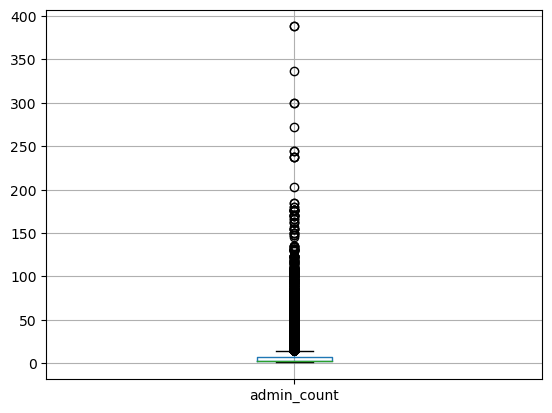

In [121]:
# merge icu and emar drug interactions

mergeable_hosp_interactions = pd.DataFrame(hosp_drug_interactions[['subject_id', 'hadm_id', 'stay_id']])
mergeable_hosp_interactions['drug_a_item_id'] = hosp_drug_interactions.medication_1
mergeable_hosp_interactions['drug_b_item_id'] = hosp_drug_interactions.medication_2
mergeable_hosp_interactions['dose_b_time'] = hosp_drug_interactions.charttime_2
mergeable_hosp_interactions['event_count'] = 0 # dummy value

combined_drug_interactions = pd.concat([icu_drug_interactions, mergeable_hosp_interactions])

print(combined_drug_interactions.columns)
print(len(combined_drug_interactions))
counts = combined_drug_interactions.groupby(['hadm_id', 'drug_a_item_id', 'drug_b_item_id']).count()
print(len(counts))
print(counts.subject_id.describe(percentiles=[0.25,0.5,0.75,0.9, 0.99]))
combined_drug_interactions['admin_count'] = counts.reset_index().subject_id

combined_drug_interactions.boxplot(column='admin_count')

combined_drug_interactions = combined_drug_interactions[combined_drug_interactions.admin_count < (7 + 1.5 * 5)] # 3 * IQR
print(combined_drug_interactions.admin_count.describe(percentiles=[0.25,0.5,0.75,0.9, 0.99]))

combined_drug_interactions

<Axes: >

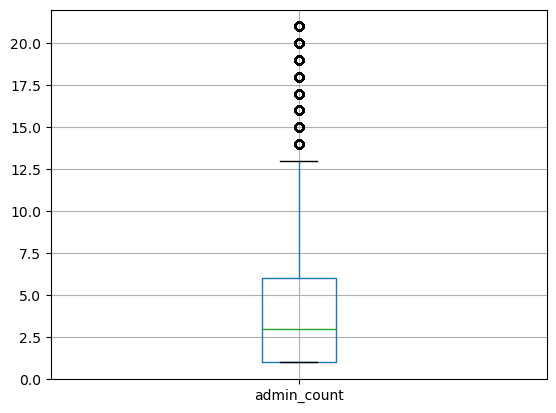

In [122]:
combined_drug_interactions.boxplot(column='admin_count')

In [123]:
combined_drug_interactions["hadm_id"].nunique()

7659

In [107]:
from detectdd.serializer import Serializer 
serializer = Serializer()
serializer.write_total_drug_interactions(combined_drug_interactions)

Saved cohort to ..\out\total-drug-interactions.out


In [108]:
serializer.write_icu_drug_interactions(icu_drug_interactions)

Saved cohort to ..\out\icu-drug-interactions.out


In [109]:
serializer.write_emar_drug_interactions(hosp_drug_interactions.drop_duplicates())

Saved cohort to ..\out\emar-drug-interactions.out


In [110]:
serializer.read_total_drug_interactions()

Loaded cohort from ..\out\total-drug-interactions.out


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count,admin_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5,1.0
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4,1.0
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4,3.0
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4,10.0
6,10990398,27541056,32331290,225798,225893,2175-12-13 11:00:00,9,7.0
...,...,...,...,...,...,...,...,...
3410,11554445,28038733,36346298,DiphenhydrAMINE,Potassium Chloride,2133-10-08 10:38:00,0,9.0
3411,13368060,20901634,30372315,AcetaZOLamide,Aspirin,2126-06-30 08:13:00,0,3.0
3412,13368060,20901634,30372315,Aspirin,AcetaZOLamide,2126-06-29 18:47:00,0,3.0
3413,12442684,20791333,34678414,Captopril,Potassium Chloride,2135-05-16 04:06:00,0,4.0


In [111]:
print(len(combined_drug_interactions))

49552


In [112]:
print(icu_drug_interactions.event_count.sum())

icu_drug_interactions

1951152


,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count
0,10245250,26727785,32875883,225798,225893,2186-05-05 07:50:00,5
1,10404109,29867820,31722715,225798,225893,2146-12-28 20:00:00,4
2,10404109,29867820,31722715,225798,225893,2146-12-29 08:06:00,4
3,10404109,29867820,31722715,225798,225893,2146-12-31 07:56:00,4
4,10404109,29867820,31722715,225798,225893,2146-12-30 14:00:00,4
...,...,...,...,...,...,...,...
104809,15886366,20745767,37318329,221393,225166,2186-10-26 07:57:00,1
104810,16030116,28017146,37104426,221393,225166,2180-06-19 16:41:00,1
104811,16030116,28017146,37104426,221393,225166,2180-06-24 12:28:00,1
104812,16030116,28017146,37104426,221393,225166,2180-06-27 09:32:00,1


In [113]:
icu_drug_interactions.event_count.describe(percentiles=[0.25,0.5,0.75])

count     199422.0
mean      9.784036
std      15.599533
min            1.0
25%            2.0
50%            5.0
75%           11.0
max          304.0
Name: event_count, dtype: Float64

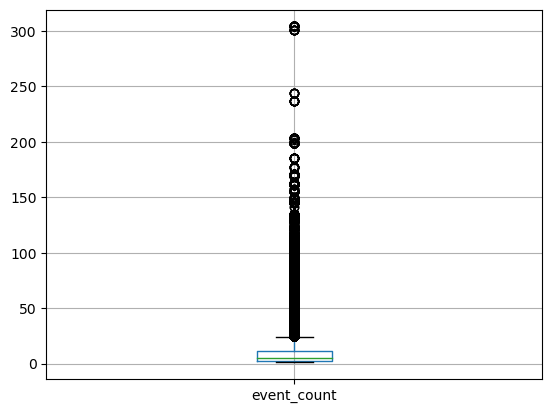

In [114]:
%matplotlib inline
plt = icu_drug_interactions.boxplot(column="event_count")


175290


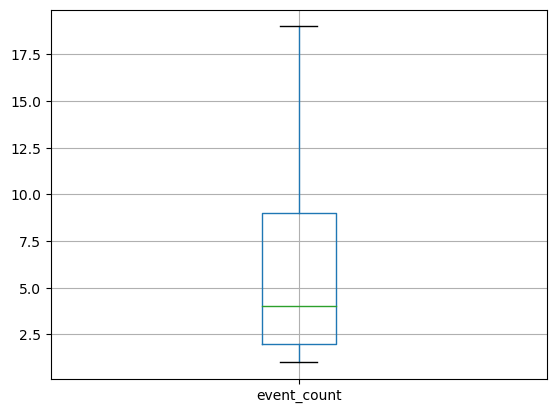

In [115]:
# remove outliers, q75 + 1.5 x IQR = 11 + 1.5 * 6 =  20
# filter for events with count below 
drug_interactions_truncated = icu_drug_interactions.loc[icu_drug_interactions.event_count < 20]
print(len(drug_interactions_truncated))
plt = drug_interactions_truncated.boxplot(column="event_count")


In [116]:
not_drug_interactions = query_for_drug_interactions(type='raw', with_interactions=False)

1501
Found 74 administered ddinter keys
Found 45 clauses


 SELECT first_ie.subject_id, 
            first_ie.hadm_id, 
            first_ie.stay_id, 
            first_ie.itemid as drug_a_item_id, 
            second_ie.itemid as drug_b_item_id, 
            MAX(second_ie.starttime) as dose_b_time, 
            count(*) as event_count
        FROM `physionet-data.mimiciv_icu.inputevents` as first_ie
        INNER JOIN `physionet-data.mimiciv_icu.inputevents` as second_ie ON first_ie.stay_id = second_ie.stay_id
        WHERE 
(first_ie.itemid IN (221282) 
            AND NOT 
            second_ie.itemid IN (225896)) OR 
(first_ie.itemid IN (225840) 
            AND NOT 
            second_ie.itemid IN (225871,221555,222011,222062,227531,229233)) OR 
(first_ie.itemid IN (221342) 
            AND NOT 
            second_ie.itemid IN (225859,221429,225153,225974)) OR 
(first_ie.itemid IN (221347) 
            AND NOT 
            second_ie.itemid IN (225857,225866,225869,225879,225882,22

In [117]:
print("Truncating cohort to 75th percentile (18)")
counts = not_drug_interactions['stay_id'].value_counts()

print(counts.describe(percentiles=[0.25, 0.5,0.75, 0.95, 0.99]))
not_drug_interactions_truncated = not_drug_interactions[not_drug_interactions['stay_id'].map(counts) <= 18]
not_drug_interactions_truncated = not_drug_interactions_truncated[not_drug_interactions_truncated.event_count < 20]

print(not_drug_interactions_truncated['stay_id'].value_counts().describe(percentiles=[0.25,0.5,0.75,0.9, 0.95, 0.99]))
print(not_drug_interactions_truncated['event_count'].describe(percentiles=[0.25,0.5,0.75,0.9, 0.95, 0.99]))
print(len(not_drug_interactions_truncated))
print(len(icu_drug_interactions))
print(f"Stay ids in truncated drug interactions {drug_interactions_truncated['stay_id'].nunique()}")
print(f"Stay ids in non-drug interactions {not_drug_interactions_truncated['stay_id'].nunique()}")
not_drug_interactions_truncated = not_drug_interactions.sample(int(len(icu_drug_interactions) / 6))
print(f"Stay ids in non drug interactions after modification {not_drug_interactions_truncated['stay_id'].nunique()}")
not_drug_interactions_truncated.to_csv(out_dir / "non-drug-interactions.csv")

Truncating cohort to 75th percentile (18)
count      38518.0
mean     12.980944
std      31.528447
min            1.0
25%            2.0
50%            4.0
75%           10.0
95%           56.0
99%          147.0
max         1297.0
Name: count, dtype: Float64
count     32411.0
mean     4.331616
std      3.936176
min           1.0
25%           1.0
50%           3.0
75%           6.0
90%          10.0
95%          13.0
99%          17.0
max          18.0
Name: count, dtype: Float64
count    140392.0
mean     3.900835
std      3.615302
min           1.0
25%           1.0
50%           3.0
75%           5.0
90%           9.0
95%          12.0
99%          17.0
max          19.0
Name: event_count, dtype: Float64
140392
199422
Stay ids in truncated drug interactions 10712
Stay ids in non-drug interactions 32411
Stay ids in non drug interactions after modification 13184


In [96]:
counts = not_drug_interactions_truncated['stay_id'].value_counts()

print(counts.describe(percentiles=[0.25, 0.5,0.75, 0.95, 0.99]))


count     13201.0
mean     2.517764
std      3.297773
min           1.0
25%           1.0
50%           1.0
75%           3.0
95%           8.0
99%          16.0
max          81.0
Name: count, dtype: Float64


In [97]:
not_drug_interactions[not_drug_interactions['stay_id'].map(counts) <= 18]

,subject_id,hadm_id,stay_id,drug_a_item_id,drug_b_item_id,dose_b_time,event_count
1,16302564,27374757,34953703,227690,221828,2115-08-26 21:09:00,13
2,18837391,23317190,37598381,221393,225158,2172-10-07 11:08:00,2
3,19131048,20480844,35630749,221282,225158,2143-05-02 02:07:00,2
4,11410426,27299736,39722758,227690,225158,2115-06-29 12:06:00,28
5,17276872,23574719,34998479,221282,225158,2188-09-17 14:00:00,1
...,...,...,...,...,...,...,...
499995,12601474,20931771,34488757,221429,221906,2131-03-06 20:29:00,45
499996,18655864,23670440,34559008,221429,222168,2148-12-04 04:03:00,7
499997,15658481,25731558,34699916,221429,222168,2202-03-13 13:00:00,1
499998,10005817,28661809,31316840,221429,222168,2135-01-08 11:13:00,1
